In [9]:
import numpy as np

#math & plot
import matplotlib.pyplot as plt
%matplotlib inline

#sklearn
import sklearn.metrics as metrics
from sklearn.externals import joblib
import io_ranking as io
#debug purposes
%load_ext autoreload
%autoreload 2
#parameters
target_n_trees = 500
global_n_jobs = 8
import cPickle
def cDump(obj,fname):
    with open(fname,'w') as f:
        cPickle.dump(obj,f)
def cLoad(fname):
    with open(fname,'r') as f:
        return cPickle.load(f)
        
from StringIO import StringIO
import _matrixnetapplier as mnet


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#reading data, formulae, etc

In [10]:
with open('../formula/MSLR10k_ef.mx', 'r') as f:
    formula = mnet.MatrixnetClassifier(StringIO(cPickle.load(f))) #btw he's a regressor, not classifier

depth, nTrees, itr = formula.iterate_trees().next()
trees = [tree for tree in itr]
print len(trees), '==',nTrees

9997 == 9997


In [11]:
read = True
fname = '../dumps/thresholds.pcl'
if not read:
    thresholds = mnet.get_thresholds(trees,formula.feature_ids,0.001)
    #todo: make a LOGICALLY CONSISTENT parallel threshold extractor AND criteria selector. Right now joblib slows things down
    cDump(thresholds,fname)
else:    
    thresholds = cLoad(fname)

In [12]:
Xtr,Qtr,Ytr = io.load_csv("../data/MSLR10/mslr_train")
#indexer = np.random.randint(0,len(Ytr),size=10**5)
#Xtr,Qtr,Ytr = Xtr[indexer,:],Qtr[indexer],Ytr[indexer]

reading from ../data/MSLR10/mslr_train
done


In [13]:
from factory import RegressionFactory
#DataFactory is just a data wrapper that can handle splits, predictions, etc. 
#Used to avoid recomputing metadata at each predictions and passing large argument strings
trainFactory = RegressionFactory(Xtr.astype('float32'),Ytr.astype('int8'),
                                 weights = np.ones(Ytr.shape, dtype = 'int8'))
del Xtr,Ytr

In [14]:
Qtr.shape

(723412,)

#model

In [15]:
import smart_hierarchy as hierarchy

In [16]:
%%time
cand_thresholds = thresholds[thresholds[:,2]>100]
root = hierarchy.create_hierarchy(trainFactory,trees,cand_thresholds,
                        max_depth = 7,event_sample = 0.1,
                        threshold_sample = 1.,
                        min_events_split = 0.125,
                        min_events_leaf = 40000,#this one (if <=1) is relative to the node subsample, not all samples
                        metric = hierarchy.Penalized_entropy(hierarchy.normalized_usability_entropy, 0.25),
                        use_joblib = False, n_jobs = global_n_jobs)

3999.98894129 72341
leaf samples: 311558 / 90426
leaf samples: 411854 / 90426
depth: 0 ,nodes in the next pool: 2
9287.64467611 72341.0
leaf samples: 163534 / 90426
leaf samples: 148024 / 90426
7025.88781461 72341.0
leaf samples: 232326 / 90426
leaf samples: 179528 / 90426
depth: 1 ,nodes in the next pool: 4
17694.424401 72341.0
leaf samples: 70218 / 90426
leaf samples: 93316 / 90426
19548.4516024 72341.0
leaf samples: 72786 / 90426
leaf samples: 75238 / 90426
12455.0846655 72341.0
leaf samples: 113627 / 90426
leaf samples: 118699 / 90426
16118.042868 72341.0
leaf samples: 99051 / 90426
leaf samples: 80477 / 90426
depth: 2 ,nodes in the next pool: 4
31009.0445368 72341.0
leaf samples: 50268 / 90426
leaf samples: 43048 / 90426
25466.1304091 72341.0
leaf samples: 67485 / 90426
leaf samples: 46142 / 90426
24377.964431 72341.0
leaf samples: 75844 / 90426
leaf samples: 42855 / 90426
29213.6374191 72341.0
leaf samples: 45865 / 90426
leaf samples: 53186 / 90426
depth: 3 ,nodes in the next poo

In [17]:
from loss_functions import MSELoss

In [ ]:
%%time
trees_splitted = hierarchy.train_splitted_boosts(trees, trainFactory,root,
                                                 breadth = 1,
                                                 loss = MSELoss,
                                                 learning_rate = 0.075, 
                                                 nTrees_leaf= target_n_trees,
                                                 trees_sample_size=500,
                                                 regularizer =0.001*sum(trainFactory.weights),
                                                 verbose=True,
                                                 use_joblib = True,n_jobs = global_n_jobs,
                                                 weights_outside_leaf = 0.75, inclusion_outside_leaf =0.75) 
cDump(trees_splitted,"../dumps/prototype_hierarchy.pcl")

In [ ]:
def printTree(root,t = '',code = "",wdict = None):
    if root.isLeaf:
        print t+'Leaf',
        if wdict is not None:
            print 'w:',wdict[code],
        print 'd:',len(t),'c:',code
    else:
        print t+'Split',len(t)
        for i in [0,1]:
            printTree(root.child[i],t+'\t',code+str(i),wdict = wdict)
def getLeafWeights(root,*args,**kwargs):
    sdict = root.split(trainFactory)
    wdict = {i:sdict[i].events.shape[0] for i in sdict}
    return wdict
wdict =getLeafWeights(root)
printTree(root,wdict = wdict)


In [ ]:
Xts,Qts,Yts = io.load_csv("../data/MSLR10/mslr_test")
testFactory = RegressionFactory(Xts,Yts)

In [ ]:
pred_splt = trees_splitted.predict(testFactory)
from sklearn import metrics
print metrics.mean_squared_error(testFactory.labels,pred_splt)

In [ ]:
#moar regularization

In [ ]:
%%time
trees_splitted2 = hierarchy.train_splitted_boosts(trees, trainFactory,root,
                                                 breadth = 1,
                                                 loss = MSELoss,
                                                 learning_rate = 0.15, 
                                                 nTrees_leaf= target_n_trees,
                                                 trees_sample_size=500,
                                                 regularizer =0.001*sum(trainFactory.weights),
                                                 verbose=True,
                                                 use_joblib = True,n_jobs = global_n_jobs,
                                                 weights_outside_leaf = 0.75, inclusion_outside_leaf =0.75) 
cDump(trees_splitted,"../dumps/last_hierarchy.05.pcl")

In [ ]:
wdict =getLeafWeights(root)
printTree(root,wdict = wdict)

In [ ]:
Xts,Qts,Yts = io.load_csv("../data/MSLR10/mslr_test")
testFactory = RegressionFactory(Xts,Yts)

In [ ]:
pred_splt = trees_splitted2.predict(testFactory)
from sklearn import metrics
print metrics.mean_squared_error(testFactory.labels,pred_splt)

In [27]:
def learning_curve(formula,factory, metric,n_points = None):
    
    lcurve = []

    Ypred = np.zeros(len(factory.labels))
                  
    for i,tree_pred in enumerate(formula.staged_predict(factory)):

        Ypred += tree_pred
        lcurve.append(metric(factory.labels, Ypred,sample_weight = factory.weights))
        if n_points is not None and i >= n_points:
            break
    while n_points is not None and i < n_points:
        i+=1
        lcurve.append(lcurve[-1])
        
    return lcurve

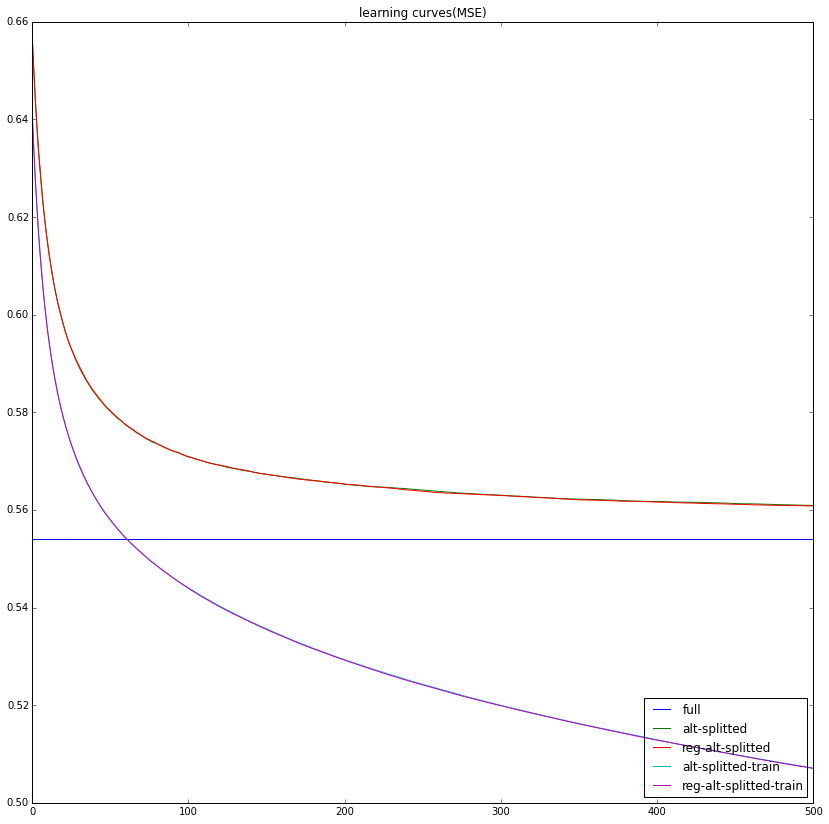

In [28]:
metric_name = 'MSE'
n_trees = target_n_trees
metric = metrics.mean_squared_error

new_splitted_lcurve = learning_curve(trees_splitted,testFactory,metric,n_trees)
new_regged_splitted_lcurve = learning_curve(trees_splitted2,testFactory,metric,n_trees)

train_new_splitted_lcurve = learning_curve(trees_splitted,trainFactory,metric,n_trees)
train_new_regged_splitted_lcurve = learning_curve(trees_splitted2,trainFactory,metric,n_trees)
#full_line = metric(testFactory.labels,y_pred_full)

p = range(n_trees+1)

plt.figure(figsize = [14,14])
plt.plot(p,[0.554 for i in p],label = "full")

plt.plot(p,new_splitted_lcurve,label = "alt-splitted")
plt.plot(p,new_regged_splitted_lcurve,label = "reg-alt-splitted")
plt.plot(p,train_new_splitted_lcurve,label = "alt-splitted-train")
plt.plot(p,train_new_regged_splitted_lcurve,label = "reg-alt-splitted-train")
plt.title('learning curves('+metric_name+')')
plt.legend(loc="lower right")


#EDA

In [29]:
smallFactory = trainFactory.select_by(np.arange(10**4))

(array([  9.78300000e+03,   1.06000000e+02,   4.40000000e+01,
          3.40000000e+01,   2.70000000e+01,   2.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.00000000e+00]),
 array([  8.62990641e-10,   8.78031445e-07,   1.75519990e-06,
          2.63236836e-06,   3.50953681e-06,   4.38670526e-06,
          5.26387372e-06,   6.14104217e-06,   7.01821063e-06,
          7.89537908e-06,   8.77254754e-06]),
 <a list of 10 Patch objects>)

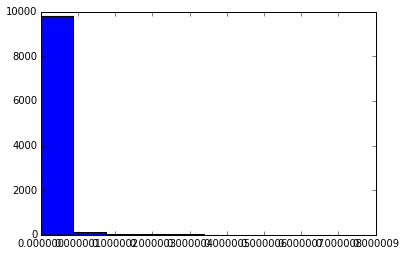

In [30]:
from greedy import PrunedFormula as pf
def compute_usability(tree,factory):
    Y = factory.predict(pf([tree]))
    return np.var(Y)
    
    
usability = [compute_usability(tree,smallFactory) for tree in trees]
plt.hist(usability)

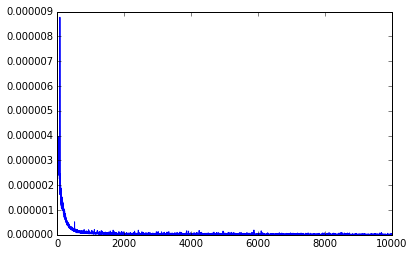

In [31]:
plt.plot(range(len(trees)),usability)

In [32]:
from greedy import PrunedFormula as pf

import random
sample_trees = pf(random.sample(trees,1000))
thresh = thresholds[thresholds[:,2]>500]

In [33]:
%%time
scores_0 = hierarchy.get_split_scores(smallFactory,thresh,sample_trees,metric = hierarchy.usability_entropy,
                            use_joblib=True,n_jobs =global_n_jobs)

CPU times: user 2.01 s, sys: 700 ms, total: 2.71 s
Wall time: 35.9 s


In [34]:
%%time
scores_1 = hierarchy.get_split_scores(smallFactory,thresh,sample_trees,metric = hierarchy.normalized_usability_entropy,
                            use_joblib=True,n_jobs = global_n_jobs)

CPU times: user 1.68 s, sys: 463 ms, total: 2.14 s
Wall time: 28.2 s


In [35]:
%%time
scores_2 = hierarchy.get_split_scores(smallFactory,thresh,sample_trees,metric = hierarchy.penalized_usability_entropy,
                            use_joblib=True,n_jobs = global_n_jobs)

CPU times: user 1.61 s, sys: 453 ms, total: 2.06 s
Wall time: 27.9 s


In [36]:
%%time
scores_3 = hierarchy.get_split_scores(smallFactory,thresh,sample_trees,metric = hierarchy.penalized_normalized_entropy,
                            use_joblib=True,n_jobs= global_n_jobs)

CPU times: user 1.67 s, sys: 491 ms, total: 2.16 s
Wall time: 28.2 s


In [37]:
split_0 = thresh[np.argmin(scores_0)]
split_1 = thresh[np.argmin(scores_1)]
split_2 = thresh[np.argmin(scores_2)]
split_3 = thresh[np.argmin(scores_3)]
print split_0
print split_1
print split_2
print split_3

[  1.30000000e+02   1.50000000e+00   3.36000000e+03]
[  1.30000000e+02   1.50000000e+00   3.36000000e+03]
[   10.    457.5  1077. ]
[   130.   37887.5   3360. ]


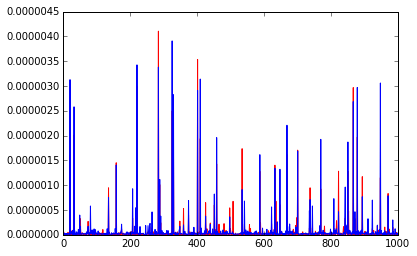

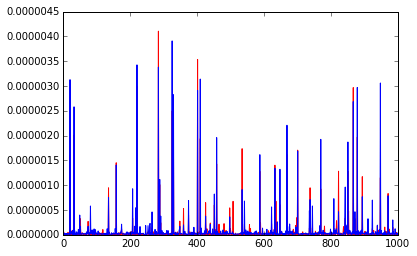

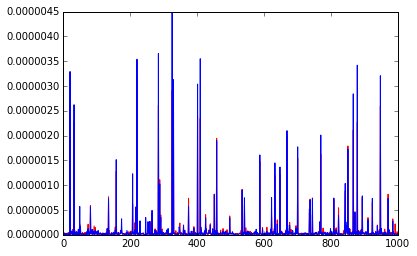

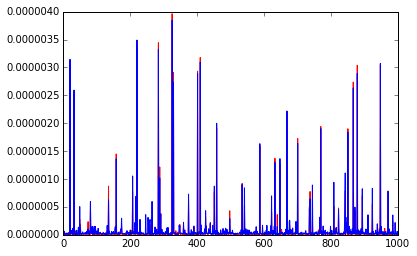

In [38]:
#BEST entropy
for feature,cut,_ in split_0,split_1,split_2,split_3:
    predicate = smallFactory.events[:,feature] > cut
    subFactories = smallFactory.split_by(predicate)
    for c, factory in zip(['red','blue'],subFactories):
        plt.plot([compute_usability(tree,factory) for tree in sample_trees],c = c)
    plt.show()

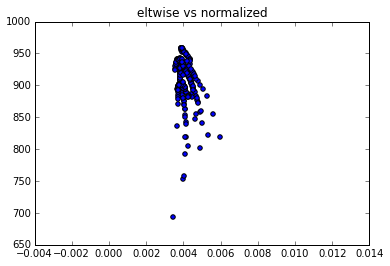

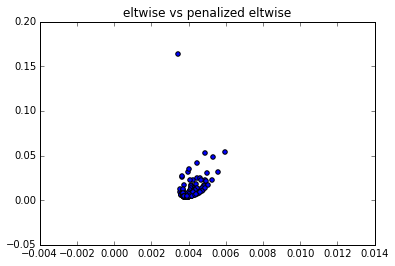

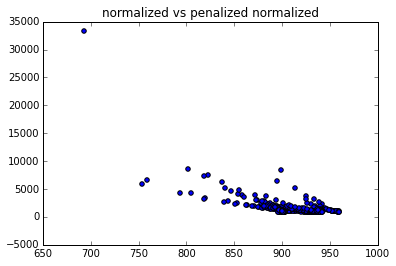

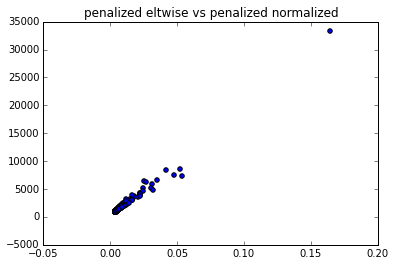

In [39]:
plt.title("eltwise vs normalized")
plt.scatter(scores_0,scores_1)
plt.show()
plt.title("eltwise vs penalized eltwise")
plt.scatter(scores_0,scores_2)
plt.show()
plt.title("normalized vs penalized normalized")
plt.scatter(scores_1,scores_3)
plt.show()
plt.title("penalized eltwise vs penalized normalized")
plt.scatter(scores_2,scores_3)
plt.show()

In [40]:
%%time
scores_4 = hierarchy.get_split_scores(smallFactory,thresh,sample_trees,metric = hierarchy.Penalized_entropy(hierarchy.normalized_usability_entropy, 0.25),
                            use_joblib=True,n_jobs= global_n_jobs)


CPU times: user 1.65 s, sys: 578 ms, total: 2.23 s
Wall time: 28.2 s


In [41]:
#BEST entropy
with split_4 as feature,cut,_:
    predicate = smallFactory.events[:,feature] > cut
    subFactories = smallFactory.split_by(predicate)
    for c, factory in zip(['red','blue'],subFactories):
        plt.plot([compute_usability(tree,factory) for tree in sample_trees],c = c)
    plt.show()

NameError: name 'split_4' is not defined